In [15]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import transformer_lens
import urllib
from matplotlib.gridspec import GridSpec
import tqdm
import transformers
import os
import math
import einops
import functools
import numpy as np

device = "cpu"
matplotlib.rc('font', size=14)

## utils

In [2]:
def download_file():
    if not os.path.exists(filename):
        print(f"Downloading {input_url}...")
        urllib.request.urlretrieve(input_url, filename)
        print(f"Downloaded {filename}")
    else:
        print(f"{filename} already exists. Skipping download.")

def get_sentences():
    download_file()
    sentences = open(filename).read().splitlines()
    setences_tokens_list = [x[:seq_length] for x in model.tokenizer(sentences).input_ids if len(x) > seq_length]
    return torch.IntTensor(setences_tokens_list[:batch_size])

def repeat_token(token_id, length, bos_token_id = None):
    bos_token_id_per_model = {
        'meta-llama/Llama-2-7b-hf': 1,
        'EleutherAI/pythia-12b': 0,
        'google/gemma-7b': 2,
        'mistralai/Mistral-7B-v0.1': 1,
    }
    if bos_token_id is None:
        bos_token_id = bos_token_id_per_model[tokenizer_name]
        
    repeated_input = token_id.repeat((1, length)).long()
    if bos_token_id is None:
        return repeated_input
    return torch.hstack([torch.ones((len(repeated_input), bos_token_id)), repeated_input]).long() # prepend

def repeat(token_str, n, with_bos = False):
    tokens = tokenizer.encode(" ".join([token_str] * n), add_special_tokens=bool(with_bos), return_tensors="pt")
    return tokens

def get_log_norm(w, sink_layer, n=450):
    repeated_input = repeat(w, n, with_bos=1)
    logits, cache = model.run_with_cache(repeated_input, stop_at_layer=sink_layer + 1)
    return cache[f'blocks.{sink_layer}.hook_resid_post'].norm(dim=-1)[0].log()

def get_mean_log_norm():
    data = open("Attention sinkhole backup/input.txt", "r").read()[:1000]
    logits, cache = model.run_with_cache(data, stop_at_layer=attention_sink_layer + 1)
    norms =  cache[f'blocks.{attention_sink_layer}.hook_resid_post'].norm(dim=-1)[0][1:]
    return norms.mean().log()

def find_sink_layer(model, max_sink_layer: int | None = None) -> int:
    max_sink_layer = max_sink_layer or model.cfg.n_layers
    empty_seq = ""
    empty_seq_cache = model.run_with_cache(empty_seq, stop_at_layer=max_sink_layer)[1]
    first_token_mlp_norms = torch.Tensor([empty_seq_cache[f'blocks.{i}.hook_mlp_out'][0, 0].norm() for i in range(max_sink_layer)])
    norms_mean = first_token_mlp_norms.mean()
    norms_std = first_token_mlp_norms.std()
    
    cond = first_token_mlp_norms > norms_mean + 2 * norms_std # some heuristic, norms of sink layer are drastically high
    sink_layer = cond.int().argmax().item()
    assert cond[sink_layer], "could not find uniquly high norm" # Verify the condition applies
    
    return sink_layer

def remove_neuron(x, hook, nid, s):
    x[:,s, nid] = 0
    return x

## preprocess

In [3]:
HF_TOKEN = os.environ.get('HF_token', None)
if HF_TOKEN is None:
    print("Warning: no huggingface token was found, some models wouldn't load")

model_name = tokenizer_name = "meta-llama/Llama-2-7b-hf"
model_output_name = {model_name.replace("/","_")}
model = transformer_lens.HookedTransformer.from_pretrained(model_name, device=device)
tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer_name, token=HF_TOKEN)

Loading checkpoint shards: 100%|██████████| 2/2 [00:46<00:00, 23.27s/it]


Loaded pretrained model meta-llama/Llama-2-7b-hf into HookedTransformer


In [4]:
input_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filename = "tinyshakespeare.txt"
download_file()

tinyshakespeare.txt already exists. Skipping download.


In [5]:
attention_sink_layer = find_sink_layer(model, 15)
print("Sink Layer is:", attention_sink_layer)

Sink Layer is: 1


## figure1

tinyshakespeare.txt already exists. Skipping download.


<Figure size 640x480 with 0 Axes>

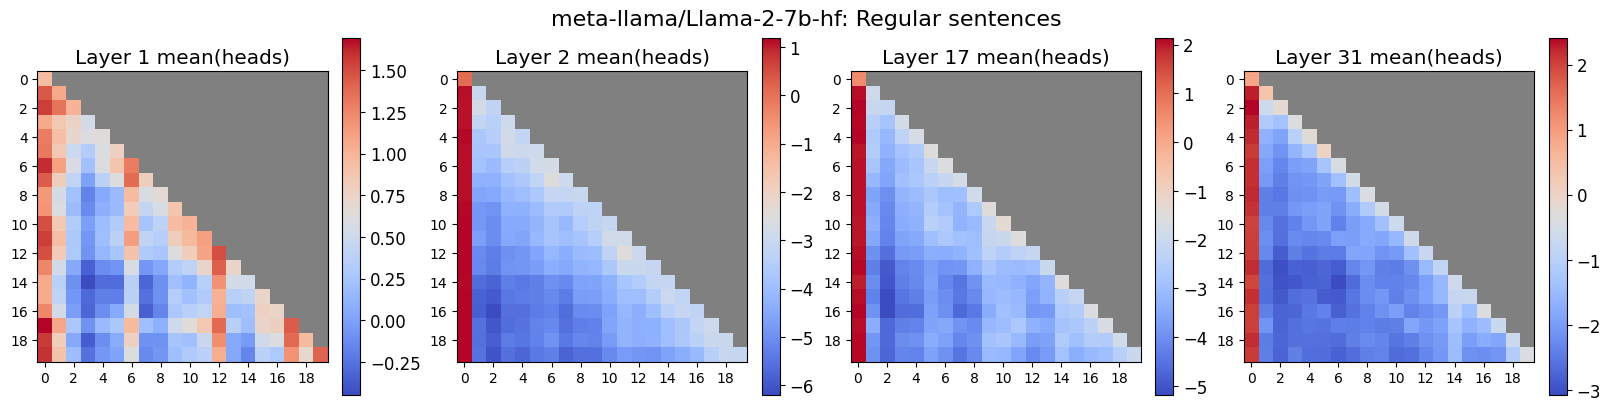

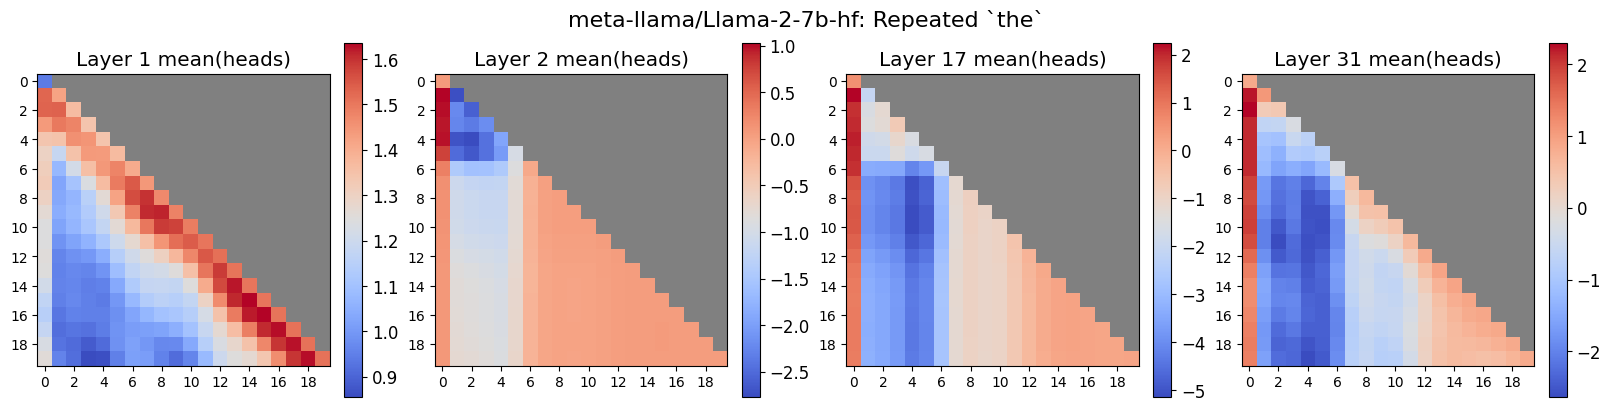

In [6]:
# based on: https://huggingface.co/blog/tomaarsen/attention-sinks#attention-sinks
# from the paper: https://cdn-uploads.huggingface.co/production/uploads/6317233cc92fd6fee317e030/juK_XBrcEe7-6InlrCSzJ.png

def get_fig_and_axes():
    fig = plt.figure(layout="constrained", figsize=(16, 4))
    gs = GridSpec(2, 8, figure=fig)
    
    axes = []
    axes += [fig.add_subplot(gs[:, 0:2])]
    axes += [fig.add_subplot(gs[:, 2:4])]
    axes += [fig.add_subplot(gs[:, 4:6])]
    axes += [fig.add_subplot(gs[:, 6:8])]

    return fig, axes

batch_size = 4
seq_length = 20
gen_random_input = lambda batch_size, seq_length=1: torch.randint(low=10, high=1000-10, size=(batch_size, seq_length))

inputs_tokens = {
    'Regular sentences': get_sentences(),
    'Repeated `the`': repeat_token(model.tokenizer.encode('the', add_special_tokens=False, return_tensors='pt'), seq_length-1),
}
outputs = {k:model.run_with_cache(v)[1] for k,v in inputs_tokens.items()}

layers_to_plot = [attention_sink_layer , attention_sink_layer + 1 , (attention_sink_layer + 1 + model.cfg.n_layers) // 2, model.cfg.n_layers-1]

cmap = matplotlib.colormaps.get_cmap('coolwarm')
cmap.set_bad(color='grey')
matplotlib.rc('font', size=12)
plt.tight_layout()

for title_per_version, activations_cache in outputs.items():
    fig, axes = get_fig_and_axes()

    for i, l_i in enumerate(layers_to_plot):
        attn_scores = activations_cache[f'blocks.{l_i}.attn.hook_attn_scores'] # <batch_size, num_heads, seq_len, seq_len>
        
        avg_attn_scores_head0 = attn_scores.mean(dim=0).mean(dim=0) # <seq_len, seq_len> 


        im = axes[i].imshow(avg_attn_scores_head0, cmap=cmap)
        axes[i].set_title(f"Layer {l_i} mean(heads)")

        axes[i].set_xticks(range(0, seq_length, 2))
        axes[i].set_yticks(range(0, seq_length, 2))
        
        axes[i].set_xticklabels(range(0, seq_length, 2), size=10)
        axes[i].set_yticklabels(range(0, seq_length, 2), size=10)
        
        plt.colorbar(im, ax=axes[i])
        
        plt.suptitle(f"{model_name}: {title_per_version}", size=16)
        plt.savefig(f'figures/figure1_model_{model_output_name}_{title_per_version}.pdf')

## figure 2 & 6

100%|██████████| 6/6 [00:19<00:00,  3.28s/it]


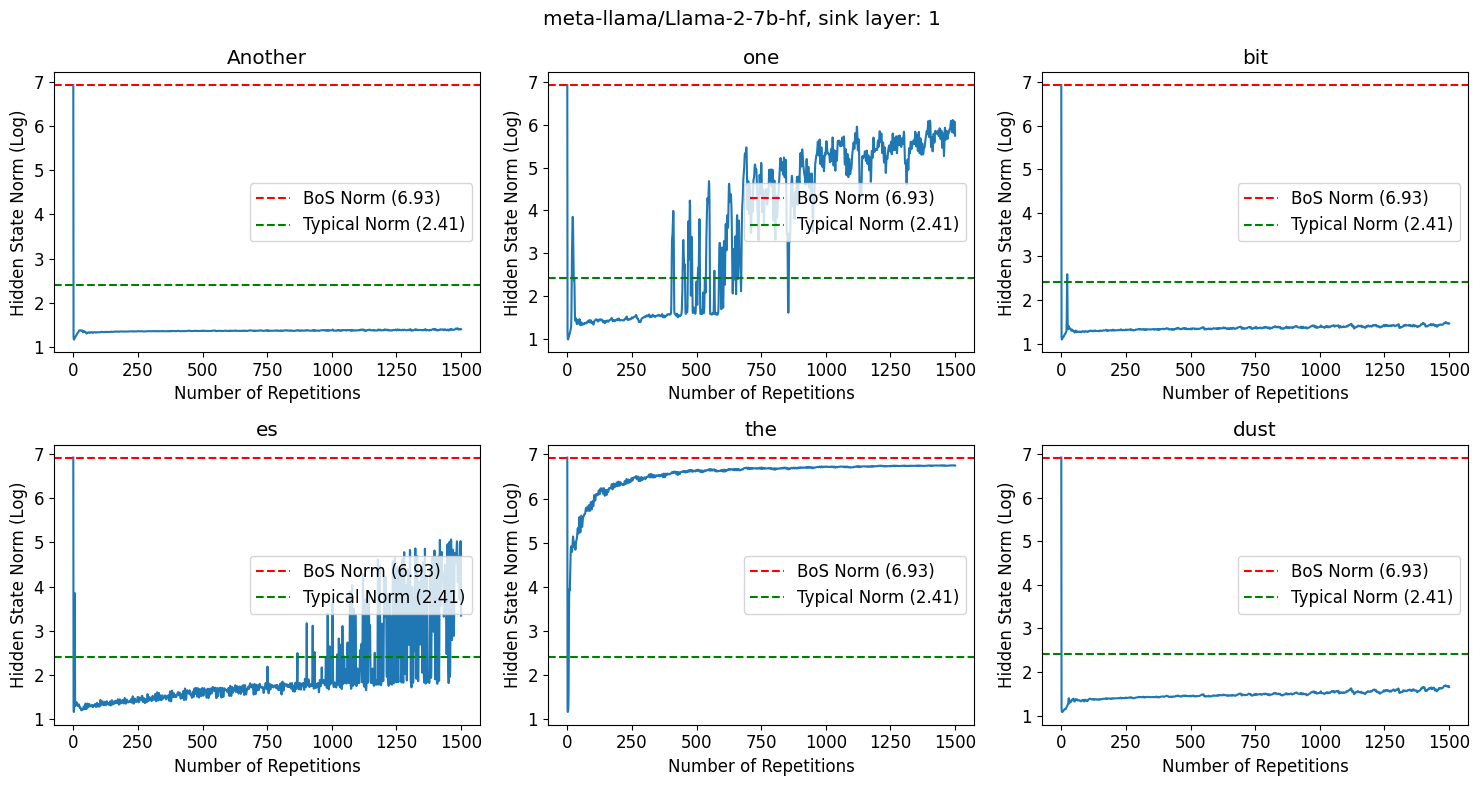

In [7]:
words_list = [x.replace(" ", "") for x in tokenizer.batch_decode(tokenizer.encode('Another one bites the dust', add_special_tokens=False))]

n_rows = 2
n_figs_per_row = math.ceil(len(words_list) / n_rows)
fig, axes = plt.subplots(n_rows, n_figs_per_row, figsize=(n_figs_per_row * 5, n_rows * 4))
axes = axes.flatten()

n_repeats = 1500

axes = axes.flatten()

for i, w in enumerate(tqdm.tqdm(words_list)):
    axes[i].set_title(w)
    norms = get_log_norm(w, attention_sink_layer, n_repeats)
    bos_norm = norms[0]
    typical_norm = get_mean_log_norm()
    
    axes[i].plot(norms)
    axes[i].set_xlabel("Number of Repetitions")
    axes[i].set_ylabel("Hidden State Norm (Log)")
    axes[i].axhline(bos_norm, color='r', linestyle='--', label=f'BoS Norm ({bos_norm:.2f})')
    axes[i].axhline(typical_norm, color='g', linestyle='--', label=f'Typical Norm ({typical_norm:.2f})')
    axes[i].legend(loc='center right', fontsize=12)

plt.suptitle(f"{model_name}, sink layer: {attention_sink_layer}")

plt.tight_layout()
plt.savefig(f'figures/norms_of_repeats_{model_output_name}.pdf')
plt.show()

## figure 3

In [8]:
w = 'the'
max_neurons = 2

repeated_input = repeat(w, n_repeats, with_bos=1)
cache = model.run_with_cache(repeated_input, stop_at_layer=attention_sink_layer + 1)[1]
neuron_outputs = cache[f'blocks.{attention_sink_layer}.mlp.hook_pre']

neuronal_influence = einops.einsum(neuron_outputs[0][-1], model.blocks[attention_sink_layer].mlp.W_out, 'N, N H -> N H')
most_inf_last_token = neuronal_influence.norm(dim=-1).topk(k=max_neurons)

candidates = most_inf_last_token.indices

candidates

tensor([ 7890, 10411])

In [9]:
print("Memory intensive operation, might take a couple of minutes. Consider using a swapfile")

n_repeats = 450
words_list = ['the', 'dust']

max_sink_layer = model.cfg.n_layers
batch_of_repeats = torch.vstack([repeat(w, n_repeats, with_bos=1)[:,:n_repeats] for w in words_list])
batch_cache = model.run_with_cache(batch_of_repeats, stop_at_layer=max_sink_layer)[1]

print("Computed activations norms (control)")

model.reset_hooks()

for candidate in candidates:
    model.blocks[attention_sink_layer].mlp.hook_pre.add_hook(functools.partial(remove_neuron, nid=candidate, s=slice(0, None)))

cache_hook = model.run_with_cache(batch_of_repeats, stop_at_layer=max_sink_layer)[1]
neuron_outputs_hook = cache_hook[f'blocks.{attention_sink_layer}.mlp.hook_pre']

model.reset_hooks()

Memory intensive operation, might take a couple of minutes. Consider using a swapfile
Computed activations norms (control)


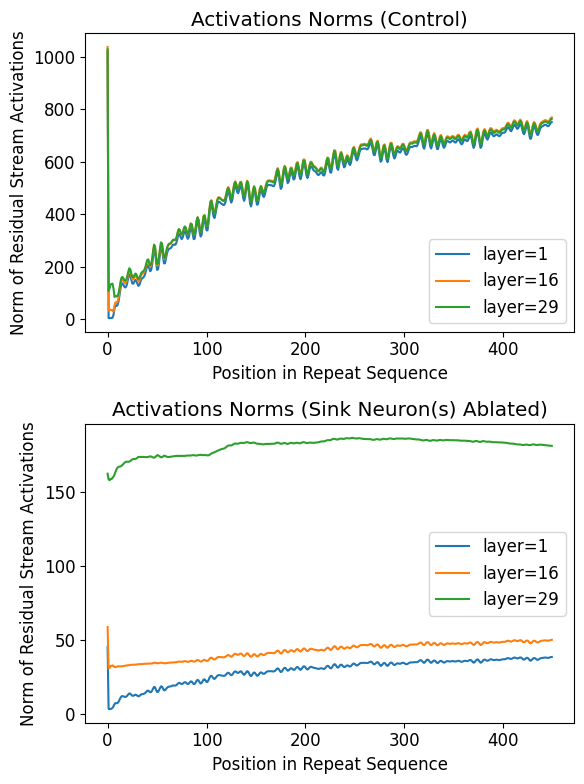

In [10]:
matplotlib.rc('font', size=12)

layers_to_plot = [attention_sink_layer, (attention_sink_layer + model.cfg.n_layers) // 2, model.cfg.n_layers-3]
fig, axes = plt.subplots(2, 1, figsize=(6, 8))

axes[0].set_title("Activations Norms (Control)")
axes[1].set_title("Activations Norms (Sink Neuron(s) Ablated)")
axes[0].set_xlabel("Position in Repeat Sequence")
axes[1].set_xlabel("Position in Repeat Sequence")
axes[0].set_ylabel("Norm of Residual Stream Activations")
axes[1].set_ylabel("Norm of Residual Stream Activations")

for i, l in enumerate(layers_to_plot):
    norms_of_sequence_in_layer_l = batch_cache[f'blocks.{l}.hook_resid_post'].norm(dim=-1)[0]#.log()
    norms_of_sequence_in_layer_l_hooked = cache_hook[f'blocks.{l}.hook_resid_post'].norm(dim=-1)[0]#.log()
    
    axes[0].plot(norms_of_sequence_in_layer_l, label=f"layer={l}")
    axes[1].plot(norms_of_sequence_in_layer_l_hooked, label=f"layer={l}")
    
axes[0].legend()
axes[1].legend()


cmap = matplotlib.colormaps.get_cmap('coolwarm')
cmap.set_bad(color='grey')
plt.tight_layout()

seq_length = n_repeats
plt.savefig(f'figures/high_norms_mediated_by_a_few_neurons2_{model_output_name}_.pdf')

## figure 4

In [16]:
with open(filename) as f:
    data = f.read()
    
data_words = data.replace("\n"," ").replace("  ", " ").split(" ")
n_samples = 1000
seq_len = 3
mlp_input_layer = 'blocks.0.hook_resid_mid'
mlp_input_layer = 'blocks.0.ln2.hook_normalized'

Q = np.zeros((seq_len, n_samples, model.cfg.d_model))

for i in tqdm.trange(0, n_samples * seq_len, seq_len):
    inp = " ".join(data_words[i:i+seq_len])
    l, c = model.run_with_cache(inp, prepend_bos=False, stop_at_layer=2)
    for j in range(seq_len):
        Q[j][i // seq_len] = c[mlp_input_layer][0][j]

# Find the most active tokens for the delta in activations:

100%|██████████| 1000/1000 [02:35<00:00,  6.44it/s]


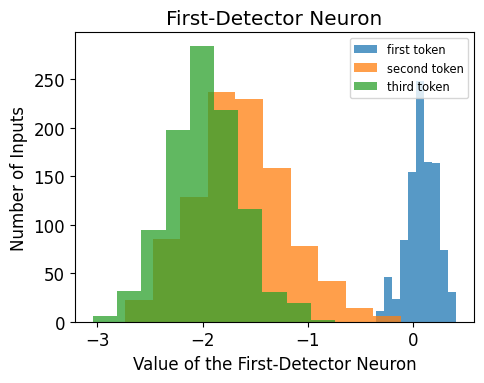

In [19]:
gates_W = model.blocks[0].mlp.W_gate.detach()
Q = torch.Tensor(Q)

top10_neurons_detecting_first_vs_second_token = ((Q[0] - Q[1]) @ gates_W).mean(axis=0).topk(k=10)

plt.rcParams.update({'font.size': 12})  

for target_neuron in top10_neurons_detecting_first_vs_second_token.indices[:1]:
    fig, ax = plt.subplots(1, 1, figsize=(5, 8 if show_delta else 4))
    
    gate0 = Q[0] @ model.blocks[0].mlp.W_gate[:,target_neuron]
    gate1 = Q[1] @ model.blocks[0].mlp.W_gate[:,target_neuron]
    gate2 = Q[2] @ model.blocks[0].mlp.W_gate[:,target_neuron]
    delta_gate = (Q[0] - Q[1]) @ model.blocks[0].mlp.W_gate[:,target_neuron]
    
    ax.hist(gate0.detach().numpy(), label="first token", alpha=0.75)
    ax.hist(gate1.detach().numpy(), label="second token", alpha=0.75)
    ax.hist(gate2.detach().numpy(), label="third token", alpha=0.75)
    
    ax.legend(fontsize='x-small', loc='upper right')
    ax.set_title(f"First-Detector Neuron")
    ax.set_xlabel("Value of the First-Detector Neuron")
    ax.set_ylabel("Number of Inputs")
    plt.tight_layout()
    plt.savefig(f'figures/figure4_model_{model_output_name}_neuron_{target_neuron}_subspaces.pdf')

## figure 5
The output of Attention 0 of repeats with a long sequence of repeats, converge to the output of Attention0 on the repeated token solely.
This implies that Attn0 is not able to correctly detect the first token of the sequence when introduced to repeats.

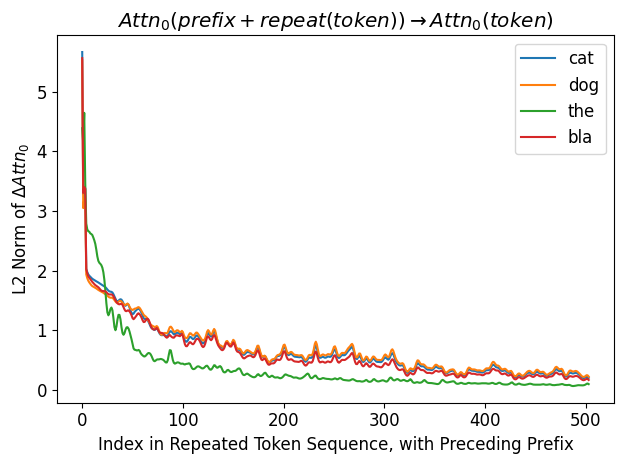

In [12]:
cos_sin = torch.nn.CosineSimilarity()
l = 'blocks.1.hook_resid_pre' # blocks.0.hook_attn_out
n_reps = 500

for token in ["cat", "dog", "the", "bla"]:
    output1, cache1 = model.run_with_cache(token, prepend_bos=False, stop_at_layer=2)
    output2, cache2 = model.run_with_cache("some prefix: " + " ".join([token] * n_reps), prepend_bos=True, stop_at_layer=2)
    
    v1 = cache1[l][0, 0]
    Q = cache2[l][0]
    metric, metric_name = cos_sin(v1, Q), "Cosine Similarity"
    metric, metric_name = (Q - v1).norm(p=2,dim=-1), r"L2 Norm of $\Delta Attn_0$"
    plt.plot(metric, label=token)


plt.xlabel("Index in Repeated Token Sequence, with Preceding Prefix")
plt.ylabel(f"{metric_name}") 
plt.title(r"$Attn_0(prefix + repeat(token)) \rightarrow Attn_0(token)$")
plt.tight_layout()
plt.legend()

# plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(f'figures/repeats_converge_to_attn0_output_on_first.pdf')
plt.show()